# Dataleakage-Free ML Model Building

To apply Kfold training steps, we copied whole processes that we implemented from other notebook to here. All processes are applying immediately after loading data into memory except for cumulative and aggregation processes. The rest of processes (cumulative and aggregation) were added into KFold stage to overcome dataleakage. You can find the code, here.

As you recall, we used Logistic Regression and Linear Regression to keep model simple. In this step, we developed all stages from beginning. 

0. Loading Data
1. Data Cleasing and Feature Engineering
2. Splitting Train (0.8) - Test (0.2)
3. KFold, K = 5
4. Testing
    - Performance Evaluation (MSE)
    - Calculate Out-of-Fold (OOF) accuracy
    - Calculate Mean Accuracy

In [8]:
import gc
import threading

import lightgbm as lightgbm
import numpy as np
import pandas as pd
import math

from time import sleep
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, RepeatedKFold

from sklearn.preprocessing import LabelEncoder
from scipy.sparse.linalg import svds
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

models = {}
__predictions = {}

if __name__ == '__main__':


    def prep(filename = 'sc_data.csv', threshold = 0.25):
    
        # reading file
        df_data = pd.read_csv(filename)
        # sorting by ts
        df_data = df_data.sort_values(['ts']).reset_index(drop=True)

        # removing invalid values of `track_duration` and `listen_duration`.
        df_data = df_data[df_data['listen_duration'] >= 0]
        df_data = df_data[df_data['track_duration'] > 0]
        df_data = df_data.reset_index(drop=True)

        #=====================================================================================

        def convert(row, t, time_diff):
            if row['country_code'] == 'US':
                return row[t] - time_diff * 60 * 60 * 1000
            else:
                return row[t]

        df_data['click_time'] = df_data['ts'] - df_data['listen_duration']
        df_data['local_click_time'] = df_data[['country_code', 'click_time']].apply(lambda x: convert(x, 'click_time', 11), 1)

        #=====================================================================================
        # feature extractions
        df_data['user_membership_time'] = df_data['ts'] - df_data['listener_signup_date']
        df_data['track_living_time'] = df_data['ts'] - df_data['track_upload_date']

        # sanity checking the range of new features
        assert len(df_data[df_data['user_membership_time'] < 0]) == 0
        assert len(df_data[df_data['track_living_time'] < 0]) == 0

        # feature extractions
        df_data['is_loop'] = (df_data['track_duration'] < df_data['listen_duration']) * 1
        df_data['n_loops'] = df_data['listen_duration'] / df_data['track_duration']
        df_data['n_loops'] = df_data['n_loops'].apply(lambda x : 0 if x == float('inf') else x)
        df_data['per_listen'] = df_data['n_loops'].apply(lambda x : 1 if x >= 1 else x)
#         df_data['skip'] = df_data['per_listen'].apply(lambda x : 1 if x < threshold else x)
#         df_data['skip'] = df_data['skip'].apply(int)

        # sanity checking the range of new features
        assert len(df_data[df_data['n_loops'] == float('inf')]) == 0
        assert len(df_data[df_data['per_listen'] > 1]) == 0

        #=====================================================================================

        def __convert_to_day_part(ts):

            if (0 == ts.hour and ts.minute == 0):
                return 'midnight'
            elif (0 <= ts.hour and ts.hour <= 5):
                return 'early_morning'
            elif (6 == ts.hour and ts.minute == 0):
                return 'dawn'
            elif (6 <= ts.hour and ts.hour <= 11):
                return 'morning'
            elif (12 == ts.hour and ts.minute == 0):
                return 'midday'
            elif (12 <= ts.hour and ts.hour <= 17):
                return 'afternoon'
            elif (18 == ts.hour and ts.minute == 0):
                return 'dusk'
            elif (18 <= ts.hour and ts.hour <= 23):
                return 'evening'

        for f in ['local_click_time', 'track_upload_date']:

            # extracting some features over date to take look at the details of dataset
            fts = f + '_ts'
            df_data[fts] = pd.to_datetime(df_data[f],unit='s')
            df_data[f + '_dow'] = df_data[fts].apply(lambda t : t.isoweekday())
            df_data[f + '_day'] = df_data[fts].apply(lambda t : t.day)
            df_data[f + '_month'] = df_data[fts].apply(lambda t : t.month)
            df_data[f + '_daypart'] = df_data[fts].apply(__convert_to_day_part)
            df_data[f + '_is_weekend'] = df_data[fts].apply(lambda t : 1 if t.day == 6 or t.day == 7 else 0) * 1

            if f == 'track_upload_date':
                df_data[f + '_year'] = df_data[fts].apply(lambda t : t.year)

            df_data.drop([fts], 1, inplace=True)

        #=====================================================================================
        df_tmp = df_data.groupby(['client_version']).aggregate({'client_version' : ['count']})
        df_tmp = df_tmp / df_tmp[('client_version', 'count')].sum()
        df_tmp = df_tmp.sort_values([('client_version', 'count')])
        df_tmp.columns = ['client_version_rank']

        df_tmp = df_tmp.reset_index()

        df_data = pd.merge(df_data, df_tmp, on=['client_version'], how='left')
        # Removing client_version
        df_data.drop(['client_version'], 1, inplace=True)

        # =================================================================
        # Applying Encoding for coverting string to decimal

        cols = df_data.select_dtypes(include='object').columns
        # .drop(['local_click_time'], er)

        encoders = {}

        for c in cols:
            encoder = LabelEncoder()
            df_data[c] = encoder.fit_transform(df_data[c].values.tolist())
            encoders[c] = encoder


        # =========================================================================== 


        table = pd.pivot_table(df_data, 
                    index='listener_id', 
                    values='listen_duration', 
                    columns='track_genre_category', 
                    aggfunc='sum', 
                    fill_value=0)

        # ==================================================================

        R = table.as_matrix()

        listening_duration_mean = np.mean(R, axis = 1)
        R_norm = R - listening_duration_mean.reshape(-1, 1)

        U, sigma, Vt = svds(R_norm, k=3)

        sigma = np.diag(sigma)

        articulated_listening_duration = np.dot(np.dot(U, sigma), Vt) + listening_duration_mean.reshape(-1, 1)
        articulated_table = pd.DataFrame(articulated_listening_duration, columns=table.columns, index=table.index)

        # ==================================================================

        df_tmp = df_data[['listener_id', 'user_membership_time']].groupby(['listener_id']).aggregate({'user_membership_time' : ['max']})
        df_tmp.columns = ['membership_time']
        df_tmp = df_tmp.reset_index()

        df_tmp = pd.merge(articulated_table.reset_index(), df_tmp, on=['listener_id']).set_index('listener_id')

        pipeline = Pipeline([
                                ('scaler', Normalizer()),
                                ('kmeans', KMeans(n_clusters=3, random_state=3333))
                            ])

        df_tmp['segment'] = pipeline.fit_predict(df_tmp.values.tolist())
        # display(df_tmp.groupby(['segment']).aggregate({'segment' :['count']}))

        df_tmp = df_tmp.reset_index()[['listener_id', 'segment']]
        df_data = pd.merge(df_data, df_tmp, on=['listener_id'])

        # Removing listener_id
        # df_data.drop(['listener_id'], 1, inplace=True)

        # =========================================================================== 
        cols = {
            'segment' : 'S',
            'listening_context' : 'LC',
            'recommender_algorithm_name' : 'RAN',
            'track_genre_category' : 'TGC',
            'listener_top_genre_category_listened' : 'LTGCL'
        }

        dfs = []
        for c in cols:
            df = pd.get_dummies(df_data[c], prefix=cols[c])
            dfs.append(df)

        df_tmp = pd.concat(dfs, 1)
        df_data = pd.concat([df_data, df_tmp], 1)

        # Removing features that were transformed into OHE
        # df_data = df_data.drop(list(cols.keys()), 1)

        drop_list = ['ts', 'segment', 'listening_context', 
                    'recommender_algorithm_name', 'click_time', 
                    'track_upload_date_daypart']
        df_data.drop(drop_list, 1, inplace=True)

        return df_data

    
    def transform(df):
            # Calculating waiting time between different track for each listener
        def cal_waiting_time(row, listener_history):
            k = row['listener_id']
            local_click_time = row['local_click_time']

            waiting_time = np.nan
            if k in listener_history:
                waiting_time = local_click_time - listener_history[k]
            listener_history[k] = local_click_time

            return waiting_time

        #=======================================================================================

        # Calculating detention time between same different track for each listener
        def cal_detention_time(row, listener_history):

            k = (row['listener_id'], row['track_id'])
            local_click_time = row['local_click_time']

            detention_time = np.nan
            if k in listener_history:
                detention_time = local_click_time - listener_history[k]
            listener_history[k] = local_click_time

            return detention_time

        #====================================================================

        # Calculating windowing(rolling)* statistics (count, mean, std) for track
        def acc_track_statistics(row, history):

            k = (row['listener_id'], row['track_id'])
            per_listen = row['per_listen']

            acc_count = 0
            total_per_listen = 0
            std_per_listen = np.nan

            if k in history:
                acc_count, total_per_listen, std_per_listen = history[k]

                if std_per_listen is np.nan:
                    std_per_listen = 0

                acc_std_per_listen = np.nan
                if acc_count > 0:
                    acc_std_per_listen = math.pow(acc_count * std_per_listen, 2) + math.pow(per_listen - (total_per_listen / acc_count), 2)
                    acc_std_per_listen = math.sqrt(acc_std_per_listen / acc_count)

                history[k] = (acc_count + 1, total_per_listen + per_listen, acc_std_per_listen)
            else:
                history[k] = (1, per_listen, std_per_listen)

            acc_mean_per_listen = 0
            if acc_count > 0:
                acc_mean_per_listen = total_per_listen / acc_count

            return (acc_count, acc_mean_per_listen, std_per_listen)

        # Calculating windowing(rolling)* statistics (count, percentage) for genre
        def acc_genre_statistics(row, history):
            curr_genre = row['track_genre_category']
            curr_top_genre = row['listener_top_genre_category_listened']

            acc_n_genre = 0
            if curr_genre in history:
                acc_n_genre = history[curr_genre]

            acc_per_top_genre = 0
            if curr_top_genre in history:
                acc_per_top_genre = history[curr_top_genre] / (row.name + 1)

            history[curr_genre] = acc_n_genre + 1
            return (acc_n_genre, acc_per_top_genre)

        # Calculating how many times the track was looped before
        def acc_is_loop(row, history):
            k = (row['listener_id'], row['track_id'])
            is_loop = row['is_loop']

            count = 0
            if k in history:
                count = history[k]
            history[k] = count + 1

            return count
        
        features = ['listener_id', 'local_click_time']
        df.sort_values(features, inplace=True)

        listener_history = {}
        df['waiting_time'] = df[features].apply(lambda row : cal_waiting_time(row, listener_history), 1)
        
        # sanity checking the range of new feature
        assert len(df[df['waiting_time'] < 0]) == 0
        ###=================================================

        features = ['listener_id', 'track_id', 'local_click_time']
        df.sort_values(features, inplace=True)

        listener_history = {}
        df['detention_time'] = df[features].apply(lambda row : cal_detention_time(row, listener_history), 1)

        # sanity checking the range of new feature
        assert len(df[df['detention_time'] < 0]) == 0
        ###=================================================

        df.sort_values(['listener_id', 'local_click_time', 'track_id'], inplace=True)

        cols =['acc_n_played', 'acc_mean_per_listen', 'acc_std_per_listen']
        history = {}
        df_acc_track = df.apply(lambda row: acc_track_statistics(row, history), 1)
        df_acc_track = pd.DataFrame(df_acc_track.values.tolist(), columns=cols)

        cols = ['acc_n_genre', 'acc_per_top_genre']
        history = {}
        df_acc_genre = df.apply(lambda row: acc_genre_statistics(row, history), 1)
        df_acc_genre = pd.DataFrame(df_acc_genre.values.tolist(), columns=cols)

        history = {}
        df_acc_is_loop = df.apply(lambda row: acc_is_loop(row, history), 1)

        # sanity checking the range of new features
        assert len(df_acc_track) == len(df)
        assert len(df_acc_genre) == len(df)
        assert len(df_acc_is_loop) == len(df)

        df['acc_is_loop'] = df_acc_is_loop

        df = df.reset_index(drop=True)
        df_acc_track = df_acc_track.reset_index(drop=True)
        df_acc_genre = df_acc_genre.reset_index(drop=True)
        
        df_tmp = pd.concat([df, df_acc_track, df_acc_genre], axis=1)

        # sanity checking the range of new feature
        print(len(df_tmp) == len(df))
#         assert len(df_tmp) == len(df)
        df = df_tmp
        
        return df
        
    df_data = prep()
    
#     df_data = df_data.fillna(-9999)
    df_data_X = df_data
    df_data_y = df_data['per_listen']
    
    # Split the data between training and test set
    df_train_X, df_test_X, df_train_y, df_test_y = train_test_split(df_data_X, 
                                                                    df_data_y, 
                                                                    test_size=0.2, 
                                                                    random_state=112358)

    def run():
        __K = 5
        __r = 1
        __N = __K * __r
        __delay = 20

        __threads = []        
        __lgbm_params = {

            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',           
            'max_depth': 32,
            'num_leaves': 100,
            'learning_rate': 0.01,
            'verbose': 0,
            'seed': 12341,
            'colsample_bytree': 0.95,
            'subsample': 0.95,
            'use_missing': False
        }

        def __run(k, train_index, valid_index):

            X_train, X_valid = df_train_X.iloc[train_index].copy().reset_index(drop=True), \
                               df_train_X.iloc[valid_index].copy().reset_index(drop=True)

            y_train, y_valid = df_train_y.iloc[train_index].copy().reset_index(drop=True), \
                               df_train_y.iloc[valid_index].copy().reset_index(drop=True)

            X_test = df_test_X.copy()
            X_train, X_valid, X_test = __transform_X(k, [X_train, X_valid, X_test])

            model = __create_model(k, X_train, y_train, X_valid, y_valid)
            models[k] = model
            __predictions[k] = model.predict(X_test)

            __free([X_train, X_valid, X_test, y_train, y_valid, model])

        def __transform_X(k, Xs):

            print('Fold#{} Transformation was started'.format(k))
            assert len(Xs) == 3
                        
            drop_list = [
                'per_listen',
                'track_upload_date',
                'listen_duration',
                'listener_id',
                'listener_signup_date',
                'local_click_time',
                'is_loop',
                'n_loops'
            ]
        
            result = []
            for X in Xs:
                X = transform(X)
                print('Fold#{} Transformation was done'.format(k))

                X = X.drop(drop_list, 1, errors='ignore')
                print('Fold#{} Feature Droping out was done'.format(k))

                result.append(X)
            

            return tuple(result)
            

        def __create_model(k, X_train, y_train, X_valid, y_valid):

            print('Fold#{} Model creation was started'.format(k))

            train_dataset = lightgbm.Dataset(X_train,
                                             y_train)

            valid_dataset = lightgbm.Dataset(X_valid,
                                             y_valid)
            model = lightgbm.train(
                __lgbm_params,
                train_dataset,
                num_boost_round=500,
                valid_sets=[valid_dataset, train_dataset],
                valid_names=['valid-{}-{}'.format(k, __N), 'train-{}-{}'.format(k, __N)],
                early_stopping_rounds=60,
                verbose_eval=5,
            )

            print('Fold#{} Model creation was done'.format(k))

            return model

        def __free(objs):
            for x in objs:
                del x
            gc.collect()

        def __evaluate():
            __wait()

            df_predictions = pd.DataFrame(__predictions)
            print(df_predictions.describe())
            
            df_test_y_prediction = df_predictions.mean(1)
            
            print(len(df_test_y_prediction), len(df_test_y), len(df_predictions))
            if len(df_test_y_prediction) == len(df_test_y):
                mse = mean_squared_error(df_test_y.values.tolist(), df_test_y_prediction.values.tolist())
                print('OOF MSE: {}'.format(mse))


        def __wait():
            for k in range(__N):
                __threads[k].join()
                print('Fold#{} was done...'.format(k))

        kf = RepeatedKFold(n_splits=__K, n_repeats=__r, random_state=112358)

        k = 1
        for train_index, valid_index in kf.split(df_train_X):

            t = threading.Thread(target=__run, args=(k, train_index, valid_index))

            t.start()
            __threads.append(t)

            print('Sleeping {} seconds'.format(__delay))
            sleep(__delay)

            print('Fold#{} was started...'.format(k))
            k += 1

        __evaluate()

    run()

Sleeping 20 seconds
Fold#1 Transformation was started
Fold#1 was started...
Sleeping 20 seconds
Fold#2 Transformation was started
Fold#2 was started...
Sleeping 20 seconds
Fold#3 Transformation was started
Fold#3 was started...
Sleeping 20 seconds
Fold#4 Transformation was started
Fold#4 was started...
Sleeping 20 seconds
Fold#5 Transformation was started
Fold#5 was started...
True
Fold#1 Transformation was done
Fold#1 Feature Droping out was done
True
Fold#1 Transformation was done
Fold#1 Feature Droping out was done
True
Fold#2 Transformation was done
Fold#2 Feature Droping out was done
True
Fold#3 Transformation was done
Fold#3 Feature Droping out was done
True
Fold#4 Transformation was done
Fold#4 Feature Droping out was done
True
Fold#5 Transformation was done
Fold#5 Feature Droping out was done
True
Fold#2 Transformation was done
Fold#2 Feature Droping out was done
True
Fold#1 Transformation was done
Fold#1 Feature Droping out was done
Fold#1 Model creation was started
True
Fold#

## Feature Importance for Each Fold

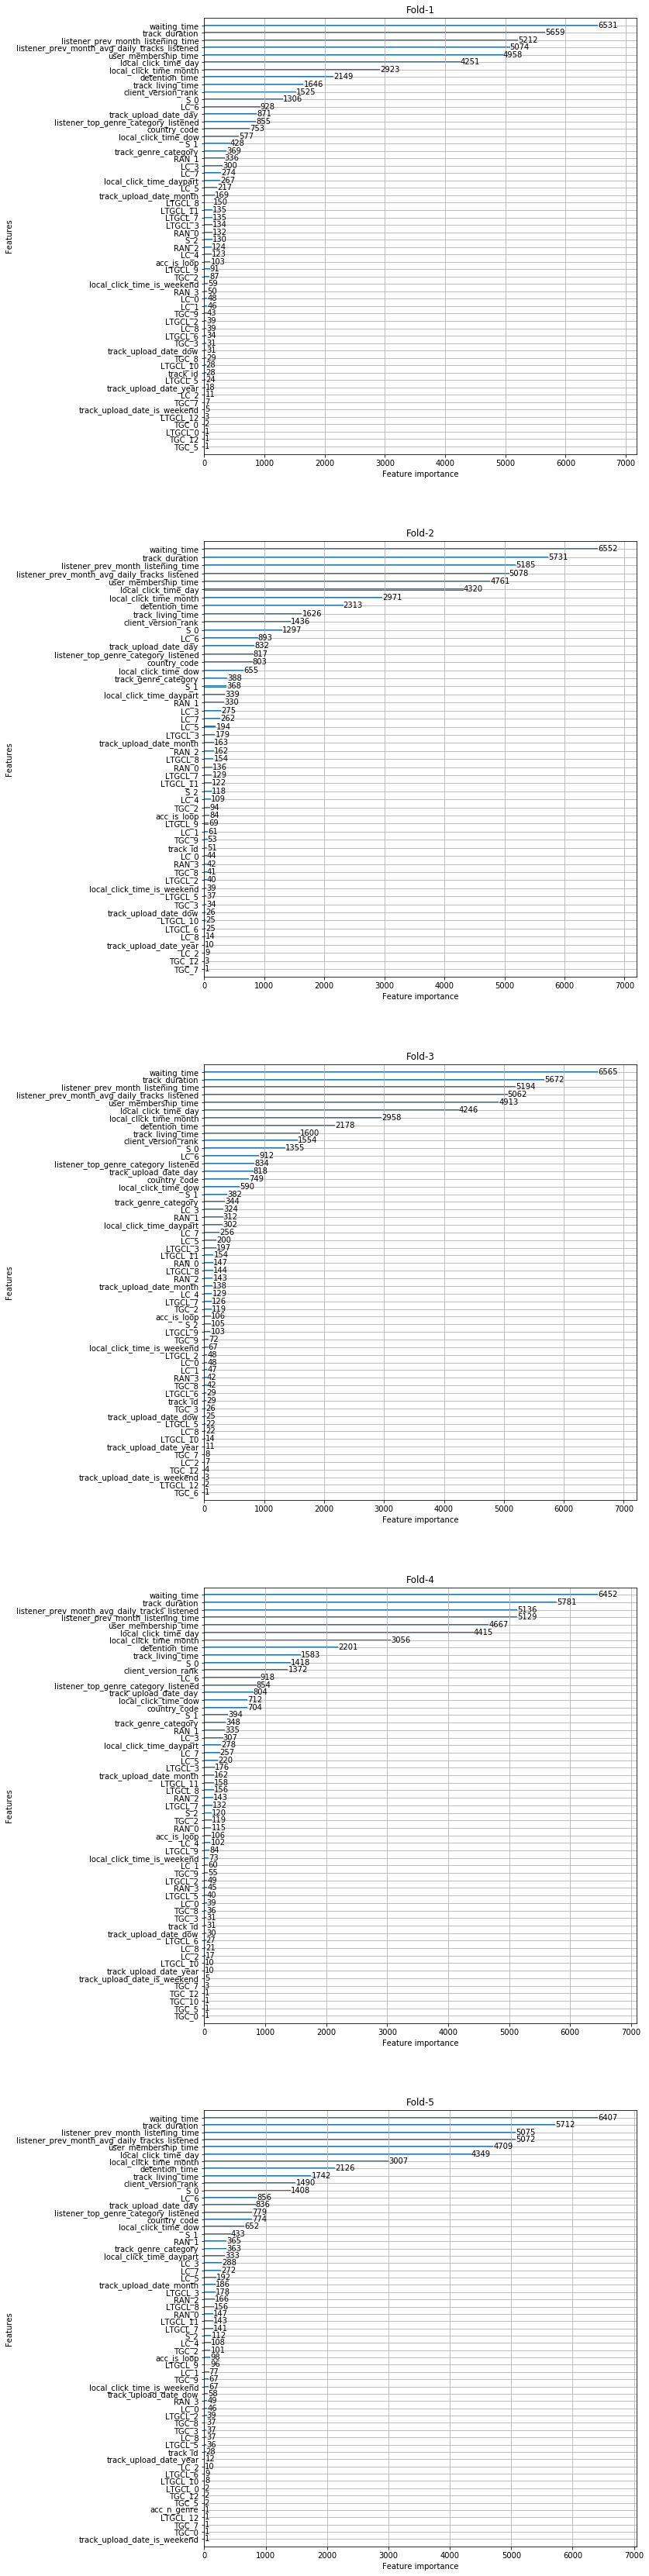

In [14]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(len(models), 1, figsize=(10, 60))

for i, k in enumerate(models):
    m = models[k]
    ax = lightgbm.plot_importance(m, ax = axes[i])
    ax.set_title('Fold-{}'.format(k))